# Vertical Regridding

Authors: [Jason Boutte](https://github.com/jasonb5) and [Jill Zhang](https://github.com/chengzhuzhang)

Updated: 11/07/24 [xcdat v0.8.0]

Related APIs:

- [xarray.Dataset.regridder.vertical](../generated/xarray.Dataset.regridder.vertical.rst)

We'll cover vertical regridding using `xgcm`. Two examples are outlined here to apply vertical regridding/remapping using ocean variables and atmosphere variables, respectively.

The data used in this example can be found in the [xcdat-data repository](https://github.com/xCDAT/xcdat-data).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook -c conda-forge xcdat xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter pooch
```

Then install the kernel from the `xcdat_notebook` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook`):

```bash
python -m ipykernel install --user --name xcdat_notebook --display-name xcdat_notebook
```

Then to select the kernel `xcdat_notebook` in Jupyter to use this kernel.


## Example 1: Remapping Ocean Variables


In [1]:
%matplotlib inline

import dask.array as da
import gsw_xarray as gsw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xcdat as xc

import warnings

warnings.filterwarnings("ignore")

/opt/miniconda3/envs/xcdat_notebook/lib/python3.13/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
# Keys for sea water potential temperature (thetao) and salinity (so) from the NCAR model in CMIP6
keys = ["so_omon_cesm2", "thetao_omon_cesm2"]

ds = xr.merge([xc.tutorial.open_dataset(x) for x in keys])

# lev coordinate is in cm and bounds is in m, convert lev to m
with xr.set_options(keep_attrs=True):
    ds.lev.load()
    ds["lev"] = ds.lev / 100
    ds.lev.attrs["units"] = "meters"

ds = ds.drop_vars(["nlon_bnds"])
ds

2025-03-14 17:03:48,385 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2025-03-14 17:03:48,385 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2025-03-14 17:03:48,412 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2025-03-14 17:03:48,412 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.


<xarray.Dataset> Size: 183MB
Dimensions:    (time: 3, lev: 60, nlat: 384, nlon: 320, d2: 2, vertices: 4)
Coordinates:
    lat        (nlat, nlon) float64 983kB -79.22 -79.22 -79.22 ... 72.19 72.19
  * lev        (lev) float64 480B 5.0 15.0 25.0 ... 5.125e+03 5.375e+03
    lon        (nlat, nlon) float64 983kB 320.6 321.7 322.8 ... 319.4 319.8
  * nlat       (nlat) int32 2kB 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * time       (time) object 24B 1850-01-15 13:00:00.000008 ... 1850-03-15 12...
Dimensions without coordinates: d2, vertices
Data variables:
    so         (time, lev, nlat, nlon) float32 88MB ...
    time_bnds  (time, d2) object 48B 1850-01-01 02:00:00 ... 1850-04-01 00:00:00
    lat_bnds   (nlat, nlon, vertices) float32 2MB -79.49 -79.49 ... 72.41 72.41
    lon_bnds   (nlat, nlon, vertices) float32 2MB 320.0 321.1 ... 320.0 319.6
    lev_bnds   (lev, d2) float32 480B 0.0 10.0 10.0 ... 5.25e+03 5.5e+03
    thetao     (time, lev, nlat, nlon) float32 88MB ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                15
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-16T23:15:40Z
    ...                     ...
    sub_experiment:         none
    sub_experiment_id:      none
    branch_time_in_parent:  219000.0
    branch_time_in_child:   674885.0
    branch_method:          standard
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.h...

### 2. Create the output grid

Related API: [xc.create_grid()](../generated/xcdat.create_grid.rst)

In this example, we will generate a vertical grid with a linear spaced level coordinate using `xc.create_grid`

Alternatively a grid can be loaded from a file, e.g.

```python
grid_urlpath = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/abrupt-4xCO2/r1i1p1f1/day/tas/gr2/v20180701/tas_day_GFDL-CM4_abrupt-4xCO2_r1i1p1f1_gr2_00010101-00201231.nc"

grid_ds = xc.open_dataset(grid_urlpath)

output_grid = grid_ds.regridder.grid
```


In [3]:
output_grid = xc.create_grid(z=xc.create_axis("lev", np.linspace(5, 537, 10)))

output_grid

<xarray.Dataset> Size: 240B
Dimensions:   (lev: 10, bnds: 2)
Coordinates:
  * lev       (lev) float64 80B 5.0 64.11 123.2 182.3 ... 418.8 477.9 537.0
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 160B -24.56 34.56 34.56 ... 507.4 507.4 566.6

### 3. Regridding using the `linear` method

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll interpolate salinity onto the new vertical grid.


2025-03-14 17:03:48,544 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2025-03-14 17:03:48,544 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.


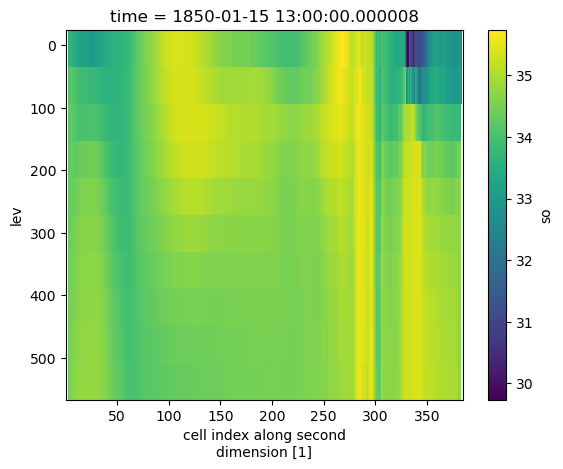

In [4]:
output = ds.regridder.vertical("so", output_grid, tool="xgcm", method="linear")

output.so.isel(time=0).mean(dim="nlon").plot()
plt.gca().invert_yaxis()

### 4. Regridding from depth to density space

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll remap salinity into density space.


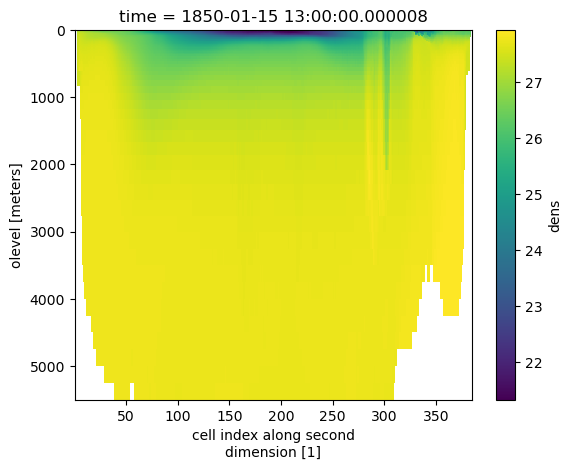

In [5]:
# Apply gsw function to calculate potential density from potential temperature (thetao) and salinity (so)
ds["dens"] = gsw.sigma0(ds.so, ds.thetao)

ds.dens.isel(time=0).mean(dim="nlon").plot()
plt.gca().invert_yaxis()

2025-03-14 17:03:50,272 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2025-03-14 17:03:50,272 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.


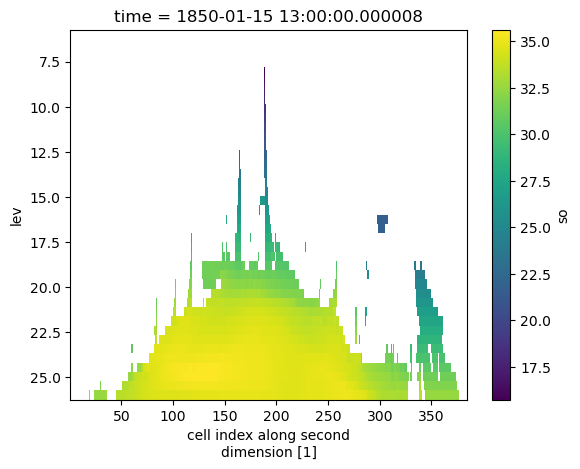

In [6]:
density_grid = xc.create_grid(z=xc.create_axis("lev", np.linspace(6, 26, 40)))

output = ds.regridder.vertical(
    "so", density_grid, tool="xgcm", method="linear", target_data="dens"
)

output.so.isel(time=0).mean(dim="nlon").plot()
plt.gca().invert_yaxis()

### 5. Regridding using the `conservative` method

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `conservative` method.

We'll transform model levels using conservative regridding. In order to perform the regridding we'll need two grid positions, the `lev` coordinate is **center** and we"ll create the **outer** points using `cf_xarray`"s `bounds_to_vertices`.


2025-03-14 17:03:51,436 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.
2025-03-14 17:03:51,436 [WARNING]: bounds.py(add_missing_bounds:194) >> The nlat coord variable has a 'units' attribute that is not in degrees.


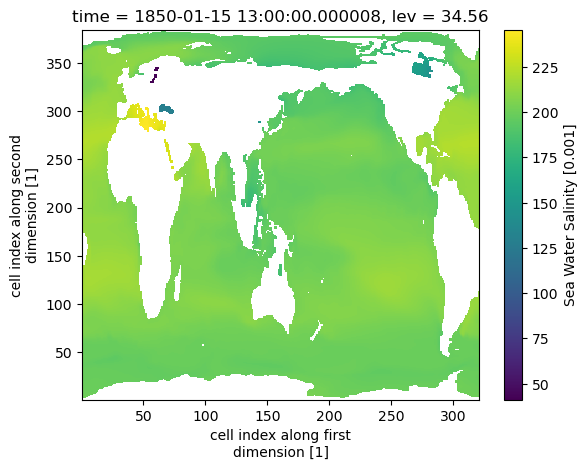

In [7]:
ds_olev = ds.cf.bounds_to_vertices("lev").rename({"lev_vertices": "olev"})

output = ds_olev.regridder.vertical(
    "so",
    output_grid,
    tool="xgcm",
    method="conservative",
    grid_positions={"center": "lev", "outer": "olev"},
)

output.so.isel(time=0).sel(lev=0, method="nearest").plot()

## Example 2: Remapping Atmosphere Variables


### 1. Open dataset

For this example, we are using monthly cloud fraction data and monthly air temperature data from the E3SM-2.0 model.


In [8]:
ds_ta = xc.tutorial.open_dataset("ta_amon_e3sm2", add_bounds=["Z"])
ds_cl = xc.tutorial.open_dataset("cl_amon_e3sm2")

In [9]:
ds_ta

<xarray.Dataset> Size: 15MB
Dimensions:    (time: 3, bnds: 2, plev: 19, lat: 180, lon: 360)
Coordinates:
  * plev       (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 24B 1850-01-16 12:00:00 ... 1850-03-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 48B ...
    lat_bnds   (lat, bnds) float64 3kB ...
    lon_bnds   (lon, bnds) float64 6kB ...
    ta         (time, plev, lat, lon) float32 15MB ...
    plev_bnds  (plev, bnds) float64 304B 1.038e+05 9.625e+04 ... 300.0 -100.0
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           36500.0
    creation_date:                   2022-08-31T00:29:52Z
    ...                              ...
    license:                         CMIP6 model data produced by E3SM-Projec...
    cmor_version:                    3.6.1
    tracking_id:                     hdl:21.14100/6e383052-7075-49db-a426-67d...
    version:                         v20220830
    references:                      Golaz, J.-C., L. P. Van Roekel, X. Zheng...
    DODS_EXTRA.Unlimited_Dimension:  time

### 2. Create the output grid

Related API: [xc.create_grid()](../generated/xcdat.create_grid.rst)

In this example, we will generate a grid with a linear spaced level coordinate.


In [10]:
output_grid = xc.create_grid(z=xc.create_axis("lev", np.linspace(100000, 1, 13)))

output_grid

<xarray.Dataset> Size: 312B
Dimensions:   (lev: 13, bnds: 2)
Coordinates:
  * lev       (lev) float64 104B 1e+05 9.167e+04 8.333e+04 ... 8.334e+03 1.0
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 208B 1.042e+05 9.583e+04 ... -4.166e+03

### 3. Remapping air temperature on pressure levels to a set of target pressure levels.

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `log` method.

We'll remap pressure levels.


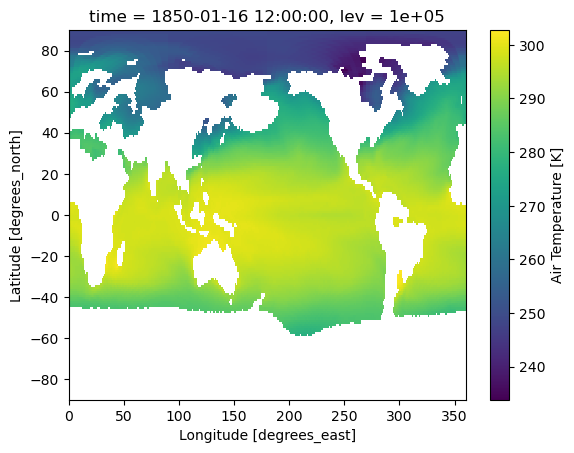

In [11]:
# Remap from original pressure level to target pressure level using logarithmic interpolation
# Note: output grids can be either ascending or descending
output_ta = ds_ta.regridder.vertical("ta", output_grid, method="log")

output_ta.ta.isel(time=0, lev=0).plot()

### 4: Remap cloud fraction from model hybrid coordinate to pressure levels

Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll remap cloud fraction into pressure space.


In [12]:
# Build hybrid pressure coordinate
def hybrid_coordinate(p0, a, b, ps, **kwargs):
    return a * p0 + b * ps


pressure = hybrid_coordinate(**ds_cl.data_vars)

pressure

<xarray.DataArray (lev: 72, time: 3, lat: 180, lon: 360)> Size: 112MB
array([[[[6.85818450e+04, 6.85818450e+04, 6.85818450e+04, ...,
          7.05259253e+04, 7.05259253e+04, 7.05259253e+04],
         [6.92225598e+04, 6.92220606e+04, 6.92210543e+04, ...,
          7.13934393e+04, 7.13948044e+04, 7.13954831e+04],
         [6.96804641e+04, 6.96804641e+04, 6.96804641e+04, ...,
          7.20169379e+04, 7.20169379e+04, 7.20169379e+04],
         ...,
         [1.01909534e+05, 1.01909534e+05, 1.01909534e+05, ...,
          1.01960629e+05, 1.01960629e+05, 1.01960629e+05],
         [1.01971028e+05, 1.01971098e+05, 1.01971230e+05, ...,
          1.02018331e+05, 1.02018207e+05, 1.02018144e+05],
         [1.02057070e+05, 1.02057070e+05, 1.02057070e+05, ...,
          1.02098617e+05, 1.02098617e+05, 1.02098617e+05]],

        [[6.85818450e+04, 6.85818450e+04, 6.85818450e+04, ...,
          7.05259253e+04, 7.05259253e+04, 7.05259253e+04],
         [6.92225598e+04, 6.92220606e+04, 6.92210543e+04, ...,
          7.13934393e+04, 7.13948044e+04, 7.13954831e+04],
         [6.96804641e+04, 6.96804641e+04, 6.96804641e+04, ...,
          7.20169379e+04, 7.20169379e+04, 7.20169379e+04],
...
         [1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01],
         [1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01],
         [1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01]],

        [[1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01],
         [1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01],
         [1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01],
         ...,
         [1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01],
         [1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01],
         [1.23825413e+01, 1.23825413e+01, 1.23825413e+01, ...,
          1.23825413e+01, 1.23825413e+01, 1.23825413e+01]]]])
Coordinates:
  * lev      (lev) float64 576B 0.9985 0.9938 0.9862 ... 0.0001828 0.0001238
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) object 24B 1850-01-16 12:00:00 ... 1850-03-16 12:00:00

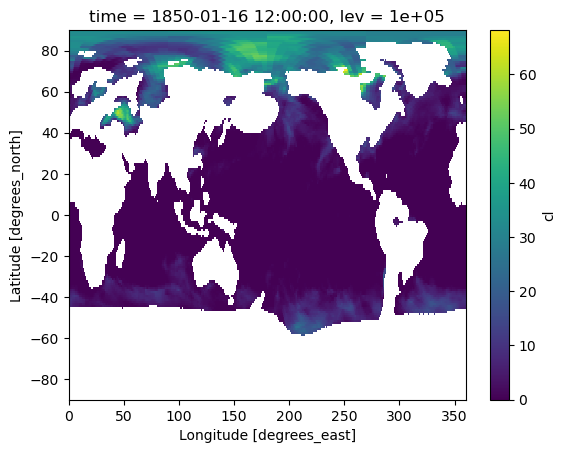

In [13]:
new_pressure_grid = xc.create_grid(
    z=xc.create_axis("lev", np.linspace(100000, 1, 13))
)

output_cl = ds_cl.regridder.vertical(
    "cl", new_pressure_grid, method="linear", target_data=pressure
)

output_cl.cl.isel(time=0, lev=0).plot()

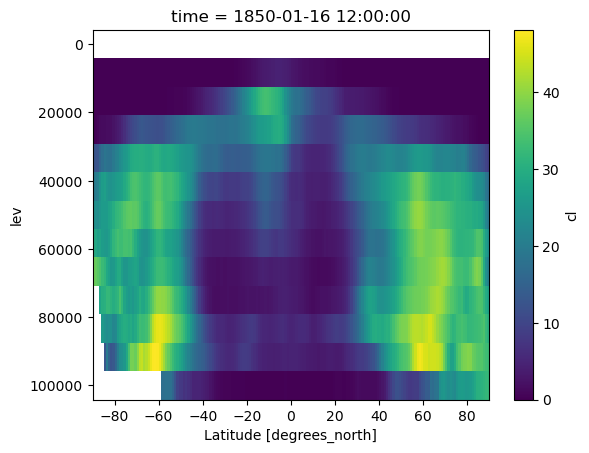

In [14]:
output_cl.cl.isel(time=0).mean(dim="lon").plot()
plt.gca().invert_yaxis()